# 介绍

随着电子商务的迅速发展，在线购物平台面临着管理大量商品的挑战。在线杂货店，尤其是像XYZ公司这样的企业，拥有成千上万种不同的商品，手动对这些商品进行分类不仅耗时耗力，还容易出现分类不准确的情况。为了提升用户体验，帮助顾客更快地找到所需商品，自动化分类成为了一个迫切的需求。

通过分析用户的购买历史，我们可以挖掘出商品之间的潜在联系，尤其是那些常被顾客一起购买的商品。这种基于数据的商品聚类方法能够有效替代传统的手动分类，既提高了分类的科学性，也让顾客能更便捷地浏览和购买商品。此外，数据科学的应用不仅限于分类，还能帮助企业识别最具价值的顾客群体，从而更有针对性地进行市场推广。

本次项目的目标是通过用户的购买历史，自动识别那些经常被一起购买的商品，并将这些商品归入同一个类别。此外，我们还会识别出那些购买最多商品的顾客，以及每个商品的“最大粉丝”——也就是购买该商品最多的顾客。这些数据将为公司创始人与重点顾客的互动提供支持，并为提升公司整体运营效率打下基础。

# 导入数据集

导入常见的库：

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

导入数据集：

In [34]:
item_to_id = pd.read_csv("./../dataset/09. grocery/item_to_id.csv")
item_to_id.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [35]:
history = pd.read_csv("./../dataset/09. grocery/purchase_history.csv")
history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


# 数据探索

两个数据集的信息：

In [36]:
item_to_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 900.0+ bytes


In [37]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


查看非独特商品的数量情况：

In [38]:
# 计算 item_to_id 数据集中每个商品名称出现的次数
item_counts = item_to_id['Item_name'].value_counts()

# 筛选出出现次数大于1的商品名称
non_unique_items = item_counts[item_counts > 1]

print("Non-unique item names and their counts:")
print(non_unique_items)

Non-unique item names and their counts:
Series([], Name: count, dtype: int64)


每个商品名称在 item_to_id 数据集中都是唯一的，没有重复出现的商品名称。这意味着每种商品都有一个独一无二的标识。

In [39]:
# 查看用户的情况
# 计算 item_to_id 数据集中每个商品名称出现的次数
user_counts = history['user_id'].value_counts()

# 筛选出出现次数大于1的用户情况
non_unique_user = user_counts[user_counts > 1]

print("Non-unique users names and their counts:")
print(non_unique_user)
print(len(non_unique_user))

Non-unique users names and their counts:
user_id
653800     7
31625      7
884172     7
696000     7
617988     6
          ..
902872     2
470361     2
1367550    2
173320     2
40435      2
Name: count, Length: 10389, dtype: int64
10389


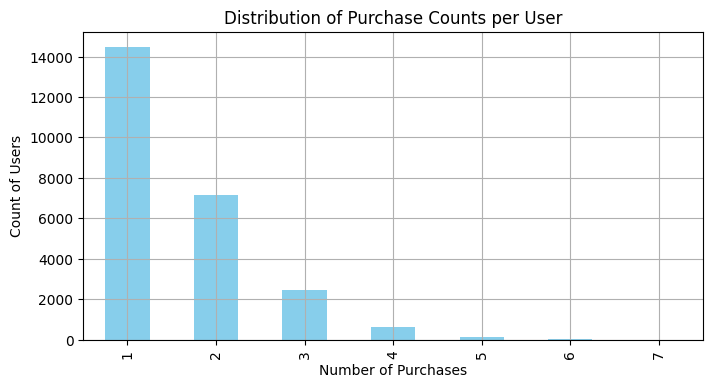

In [40]:
# 计算每个用户的购买次数
user_counts = history['user_id'].value_counts()

# 统计每个购买次数的用户数量
purchase_count_distribution = user_counts.value_counts().sort_index()

# 绘制柱状图
plt.figure(figsize=(8, 4))
purchase_count_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Purchase Counts per User')
plt.xlabel('Number of Purchases')
plt.ylabel('Count of Users')
plt.grid(True)
plt.show()

# 数据处理

history的id包含了购买的物品的id：

In [41]:
history['id']

0                                                    27,26
1                                                  6,47,17
2                             18,12,23,22,27,43,38,20,35,1
3                                       9,23,2,20,26,47,37
4        31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4...
                               ...                        
39469                                        48,42,44,10,2
39470                23,21,26,27,41,9,47,43,20,40,16,24,46
39471                3,39,28,4,1,43,47,27,18,25,44,10,30,2
39472                             13,39,20,32,37,1,3,18,34
39473                      39,40,20,3,10,42,38,43,28,25,13
Name: id, Length: 39474, dtype: object

但是可以发现，id列里面存在着众多的物品，他们的id被使用，进行了隔离，这里需要对其进行拆分，然后得到一个类似于one-hot的表。

In [42]:
# 进行合并
def id_to_item(df):
    """ function to convert id into counts """
    # 'sum' here is adding two lists into one big list
    ids = df['id'].str.split(',').sum()
    id_list = [0 for i in range(1, 49)]
    for i in ids:
        id_list[int(i) - 1] += 1
        
    return pd.Series(id_list, index=list(range(1, 49)))

In [43]:
# get user_item count matrix
user_item_count = history.groupby('user_id').apply(id_to_item)

user_item_count.head()

C:\Users\wangjun\AppData\Local\Temp\ipykernel_5656\478941392.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_item_count = history.groupby('user_id').apply(id_to_item)


,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


# 用户分析

**购买最多**

In [44]:
user_count = user_item_count.sum(axis=1).reset_index().rename(columns={0: 'count'})
user_count.sort_values(by='count', ascending=False).head(n = 10)

,user_id,count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63
24621,1485538,62
15193,917199,62
11898,718218,60
10799,653800,60
22152,1341188,58


上述表格给出了购买最多的前十位顾客，和他们各自的购买总数。

In [45]:
item_user_most = user_item_count.apply(np.argmax, axis=0).reset_index()
item_user_most = item_user_most.rename(columns={'index': 'Item_id', 0: 'User_id'})

df = pd.merge(left=item_user_most, right=item_to_id, on='Item_id', how='left')
df[['Item_id', 'Item_name', 'User_id']]

,Item_id,Item_name,User_id
0,1,sugar,512
1,2,lettuce,512
2,3,pet items,2552
3,4,baby items,92
4,5,waffles,3605
5,6,poultry,5555
6,7,sandwich bags,2926
7,8,butter,2493
8,9,soda,4445
9,10,carrots,10238


上表给出了每个商品的购买该商品数量最多的顾客的id。

接着开始进行聚类：

In [46]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [50]:
# define the feature matrix: item_id, user_id
feature = user_item_count.T
feature.head()

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [80]:
# determine the best number of clusters
clusters = range(2, 30)
inertias = []
silhouettes = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=43)
    kmeans = kmeans.fit(feature)
    label = kmeans.predict(feature)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(feature, label))

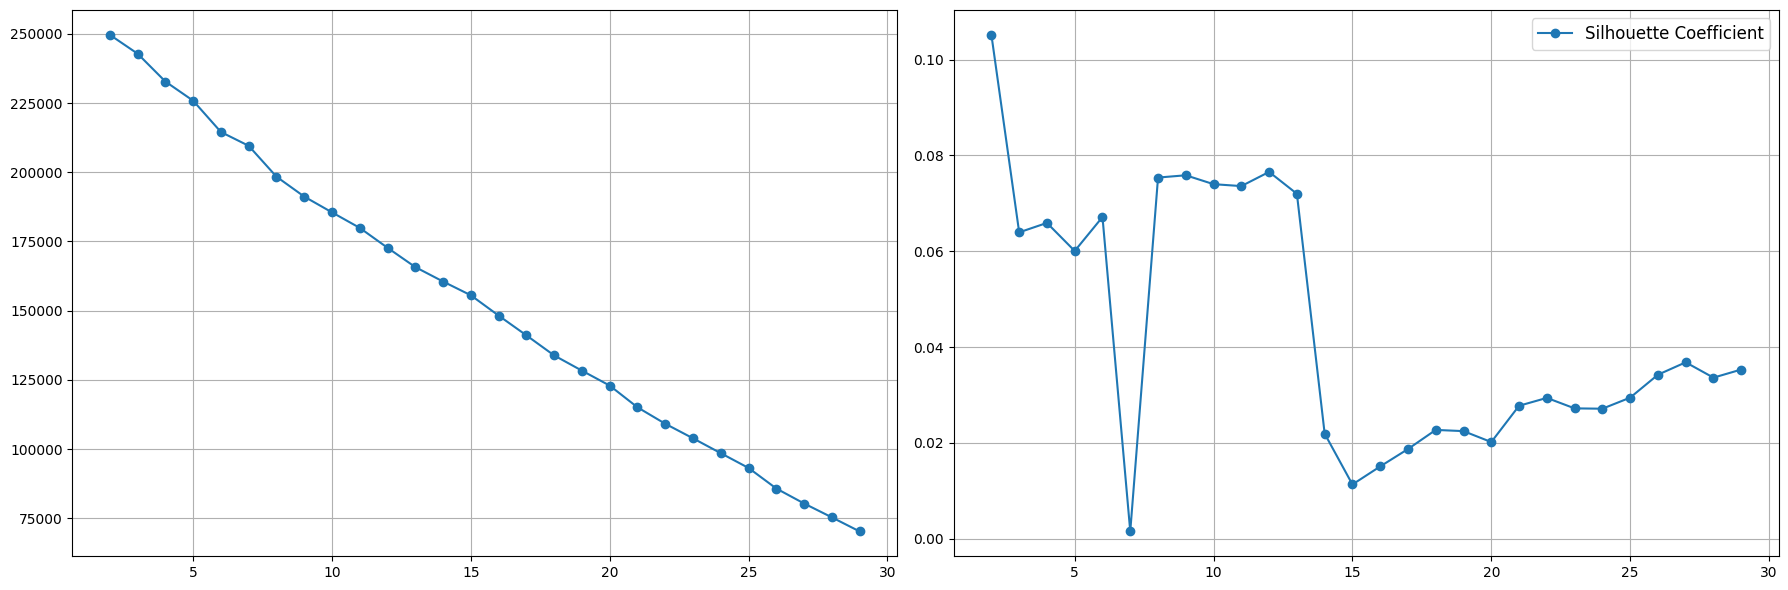

In [81]:
# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

从上述的结果来看，当聚类数量达到了7的时候，会被视作是最佳的聚类结果。

In [82]:
# build K-Means model
kmeans = KMeans(n_clusters=7, init='k-means++', random_state=42)
kmeans = kmeans.fit(feature)
label = kmeans.predict(feature)

In [83]:
# 进行降维
# PCA for dimension reduction
pca = PCA(n_components=2, random_state=42)
pca = pca.fit(feature)
pca_feature = pca.transform(feature)

查看一下降维之后的结果：

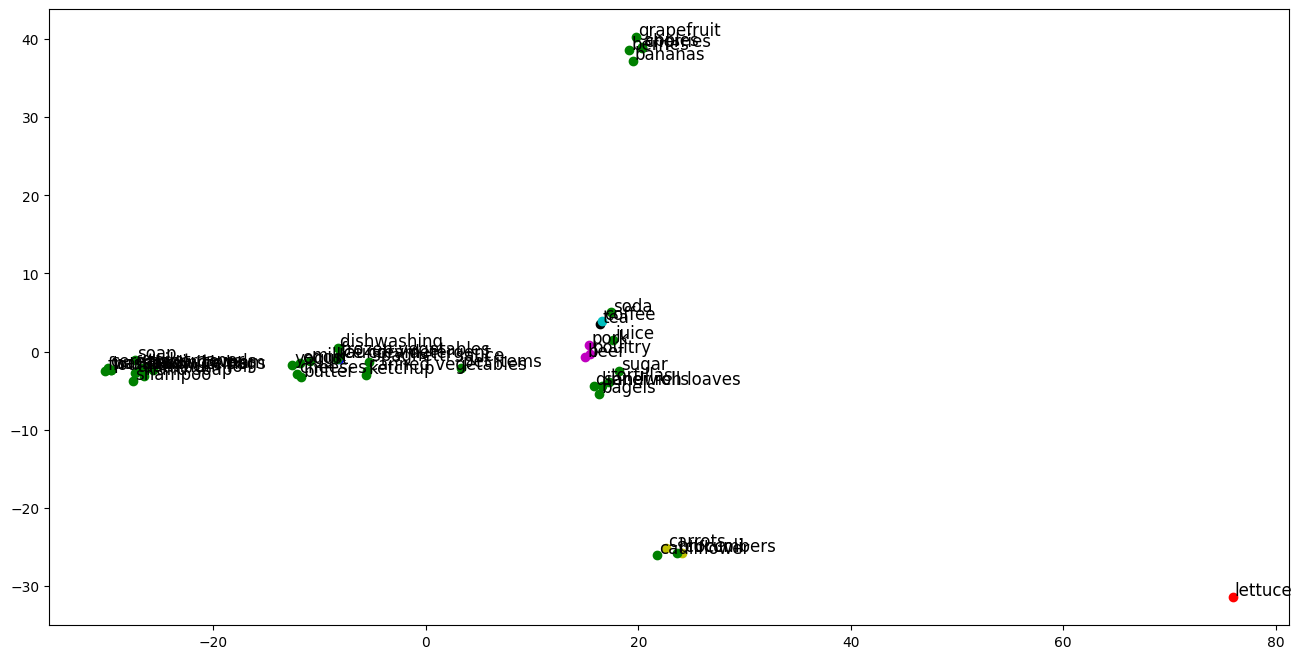

In [84]:
import matplotlib.pyplot as plt

# visualization in 2D
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize=(16, 8))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x, y, 'o', color=colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j + 1]['Item_name'].values[0]  # 提取商品名称
    ax.annotate(text=name, xy=(x+0.2, y+0.2), fontsize=12)  # 使用text代替s

plt.show()

打印一些重要的信息：

In [85]:
# print useful information
df = pd.DataFrame({'Item_id': list(range(1, 49)), 'label': label})
df = pd.merge(left=df, right=item_to_id, on='Item_id', how='left')

for i in range(0, 7):
    print(i, '\t', list(df[df['label'] == i]['Item_name']))

0 	 ['laundry detergent']
1 	 ['sugar', 'pet items', 'baby items', 'waffles', 'sandwich bags', 'butter', 'soda', 'cereals', 'shampoo', 'bagels', 'eggs', 'aluminum foil', 'milk', 'shaving cream', 'grapefruit', 'cheeses', 'frozen vegetables', 'paper towels', 'cherries', 'spaghetti sauce', 'dishwashing\xa0', 'canned vegetables', 'hand soap', 'flour', 'pasta', 'apples', 'toilet paper', 'tortillas', 'soap', 'ice cream', 'dinner rolls', 'juice', 'sandwich loaves', 'berries', 'ketchup', 'broccoli', 'cauliflower', 'bananas', 'yogurt']
2 	 ['lettuce']
3 	 ['coffee']
4 	 ['poultry', 'beef', 'pork']
5 	 ['carrots', 'cucumbers']
6 	 ['tea']


由于只有48种物品，这可能导致了一些物品缺乏了相关的物品，以至于在该物品的类别中只有该物品。